## Lección 3 Estimación de Retornos y Estimación de Covarianzas

### Objetivos Notebook Lección 3

1)	Entender cómo estimar vectores retorno de los activos con base a los datos históricos.
2)	Modelar la matriz de covarianzas usando EWMA.

### Estimación de Retorno

1) Importe la serie de datos del Bitcoin
2) Calcule el retorno anualizado del Bitcoin
3) Calcule la volatilidad anual del Bitcoin
4) Gráfique el precio del Bitcoin en escala logarítmica
5) Realice un intervalo de confianza y pruebas de hipótesis para el retono esperado.
6) Realice un intervalo de confianza y pruebas de hipótesis para el retorno esperado anualizado. 

In [1]:
import numpy as np
import pandas as pd
from librerias.finance_operators import * 

hist_bitcoin = pd.read_csv('Datos\\'+'Bitcoin_n_SnP.csv')
hist_bitcoin

C:\Users\jcamargo\AppData\Local\Temp\ipykernel_59228\211944607.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Unnamed: 0,Bitcoin,SnP 500
0,1991-07-01,NaN,377.920013
1,1991-07-02,NaN,377.470001
2,1991-07-03,NaN,373.329987
3,1991-07-05,NaN,374.079987
4,1991-07-08,NaN,377.940002
...,...,...,...
9263,2024-01-22,39507.367188,4850.430176
9264,2024-01-23,39845.550781,4864.600098
9265,2024-01-24,40077.074219,4868.549805
9266,2024-01-25,39933.808594,4894.160156


In [2]:
# Obtener retornos logarítmicos.
log_returns_bitcoin = calculateLogReturns(hist_bitcoin['Bitcoin'])
log_returns_bitcoin = log_returns_bitcoin.dropna()
log_returns_bitcoin

5850   -0.074643
5851   -0.072402
5852    0.035111
5853   -0.024968
5854    0.008317
          ...   
9263   -0.050309
9264    0.008524
9265    0.005794
9266   -0.003581
9267    0.046077
Name: Bitcoin, Length: 3418, dtype: float64

In [3]:
mu_gorro = log_returns_bitcoin.mean()
mu_gorro

0.001321135500836413

In [4]:
# Lo anualizamos
mu_gorro_anual = mu_gorro*252
mu_gorro_anual.round(6)

0.332926

In [5]:
# Obtener sigma 
sigma_gorro = np.sqrt((1/(len(log_returns_bitcoin))*(((log_returns_bitcoin-mu_gorro)**2).sum())))
sigma_gorro_anual = sigma_gorro*np.sqrt(252)
sigma_gorro_anual.round(6)

0.590842

In [6]:
import scipy.stats 
half_width = sigma_gorro_anual/np.sqrt(len(log_returns_bitcoin)/252)*scipy.stats.t.ppf(0.025, len(log_returns_bitcoin))
print((mu_gorro_anual-half_width).round(6),(mu_gorro_anual+half_width).round(6))

0.647475 0.018378


### Calculo del VaR

Ojo el cálculo del VaR al 95% se realiza con una ecuación parecida

In [7]:
mu_gorro_anual-sigma_gorro_anual*1.65

-0.6419630861038088

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import yfinance as yf
assets_df = pd.read_csv('Datos\\'+'Bitcoin_n_SnP.csv')
assets_df.index = pd.to_datetime(assets_df.iloc[:,0]) 
assets_df = assets_df.iloc[:,1:]
assets_df

,Bitcoin,SnP 500
Unnamed: 0,,
1991-07-01,NaN,377.920013
1991-07-02,NaN,377.470001
1991-07-03,NaN,373.329987
1991-07-05,NaN,374.079987
1991-07-08,NaN,377.940002
...,...,...
2024-01-22,39507.367188,4850.430176
2024-01-23,39845.550781,4864.600098
2024-01-24,40077.074219,4868.549805


### Estimación de Volatilidad S&P 500

#### Ventanas Móviles (Caso S&P 500)

A continuación se replica el ejercicio documentado en el boletín de Risk Management de Goldman Sachs de Enero del 1998.

In [9]:
hist_snp = assets_df.copy()
hist_snp = hist_snp.loc[hist_snp.index >= "1991-01-01"]
hist_snp = hist_snp.loc[hist_snp.index <= "1996-12-31"]
hist_snp['Log_Returns_snp'] = calculateLogReturns(hist_snp['SnP 500'])

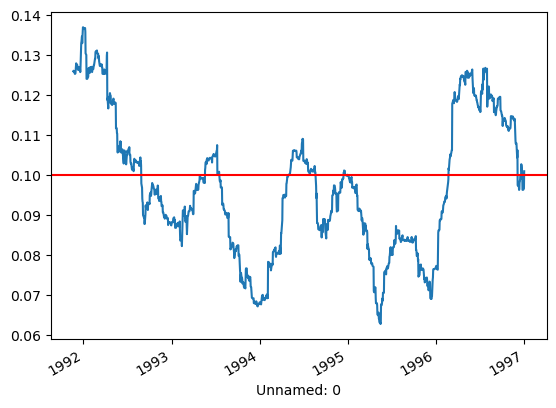

In [10]:
volatility_snp = hist_snp['Log_Returns_snp'].std()
rolling_vol = hist_snp.loc[:,'Log_Returns_snp'].rolling(window=100).apply(np.std, raw=True)*np.sqrt(252)
ax = rolling_vol.plot() 
ax.axhline(volatility_snp*np.sqrt(252), c='r')

### Estimar correlaciones y volatilidades con EWMA

A continuación encontramos la serie de pasos empleadas para obtener las volatilidades y correlaciones con EWMA 

#### Paso 1

Estimar volatilidades para los activos en cuestión en ventanas móviles.

#### Paso 2 

Estimar las covarianzas y correlaciones para los activos en cuestión en ventanas móviles. Esto implica posteriormente borrar los datos de retorno de las primeras observaciones usadas para obtener los primeros datos en ventanas móviles. 

#### Paso 3. 

Obtener las semillas como la primera desviación estándar, o la primera covarianza calculada en la ventanas para hacer el suavizamiento EWMA. 

### Paso 4

Usar semilla como la primera desviación estándar  para hacer el suavizamiento EWMA. Tomando la media diaria del retorno de los activos como apróximadamente cero. 

$$\sigma_{i,t}^{2}= \lambda * \sigma_{i,t-1}^{2}+(1-\lambda)r_{i,t-1}^2$$

Particularmente expresando el problema usando la documentación de Pandas 

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html

Si se específica la opción adjust = False. 

Se esta computando la siguiente serie de forma recursiva: 

$y_{0} = x_{0}$

$y_{t} = (1-\alpha)y_{t-1} + \alpha x_{t}$

En nuestro caso las iteraciones de la serie se harían de la siguiente manera: 

$r_{0} = \sigma_{0}^{2}$

$\sigma_{i,t}^{2} = (1-\alpha)\sigma_{t-1}^{2} + \alpha r_{i,t-1}^{2}$

Ingresando alpha $\alpha = 1 - \lambda$

$\sigma_{i,t}^{2} = (1- (1 - \lambda))\sigma_{t-1}^{2} + (1 - \lambda) r_{t-1}^{2}$

$\sigma_{i,t}^{2} = \lambda\sigma_{t-1}^{2} + (1 - \lambda) r_{t-1}^{2}$

Se sigue la misma lógica para los términos de covarianza.

$\sigma_{i,j,t}^{2} = \lambda\sigma_{i,j,t-1}^{2} + (1 - \lambda) r_{i,t-1} r_{j,t-1}$

In [11]:
window = 21
### Paso 1: Estimar volatilidades para los activos en cuestión en ventanas móviles. 
assets_df = assets_df.dropna().copy()
assets_df['Log_Returns_snp'] = calculateLogReturns(assets_df['SnP 500']) 
assets_df['Log_Returns_btc'] = calculateLogReturns(assets_df['Bitcoin'])
assets_df['Sd_snp'] = assets_df.loc[:,'Log_Returns_snp'].rolling(window=window).apply(np.std, raw=True)
assets_df['Sd_btc'] = assets_df.loc[:,'Log_Returns_btc'].rolling(window=window).apply(np.std, raw=True)
### Paso 2: Estimar las covarianzas y correlaciones para los activos en cuestión en ventanas móviles. 
cov = assets_df[['Log_Returns_snp','Log_Returns_btc']].rolling(window=window).cov()
corr = assets_df[['Log_Returns_snp','Log_Returns_btc']].rolling(window=window).corr()
corr = corr.dropna()
cov = cov.dropna()
assets_df = assets_df.dropna()
assets_df['Log_Returns_snp'].to_clipboard()
assets_df

,Bitcoin,SnP 500,Log_Returns_snp,Log_Returns_btc,Sd_snp,Sd_btc
Unnamed: 0,,,,,,
2014-10-16,382.556000,1862.760010,0.000145,-0.031436,0.009853,0.046738
2014-10-17,383.757996,1886.760010,0.012802,0.003137,0.010305,0.044372
2014-10-20,382.845001,1904.010010,0.009101,-0.002382,0.010616,0.041718
2014-10-21,386.475006,1941.280029,0.019385,0.009437,0.011514,0.041557
2014-10-22,383.157990,1927.109985,-0.007326,-0.008620,0.011547,0.037272
...,...,...,...,...,...,...
2024-01-22,39507.367188,4850.430176,0.002192,-0.052055,0.006767,0.034640
2024-01-23,39845.550781,4864.600098,0.002917,0.008524,0.005805,0.033847
2024-01-24,40077.074219,4868.549805,0.000812,0.005794,0.005478,0.033858


In [12]:
### Paso 3: Obtener las semillas como la primera desviación estándar calculada en ventanas móviles. 
sd_snp_subzero = assets_df['Sd_snp'].iloc[0]
sd_btc_subzero = assets_df['Sd_btc'].iloc[0]
sd_snp_subzero

0.009852854559955085

In [13]:
assets_df = assets_df.dropna().copy()
assets_df.loc[:,'ewma_vol_snp'] = calculateEWMAVol(assets_df['Log_Returns_snp'],sd_snp_subzero, 0.94)
assets_df.loc[:,'ewma_vol_btc'] = calculateEWMAVol(assets_df['Log_Returns_btc'],sd_btc_subzero, 0.94)

<Axes: xlabel='Unnamed: 0'>

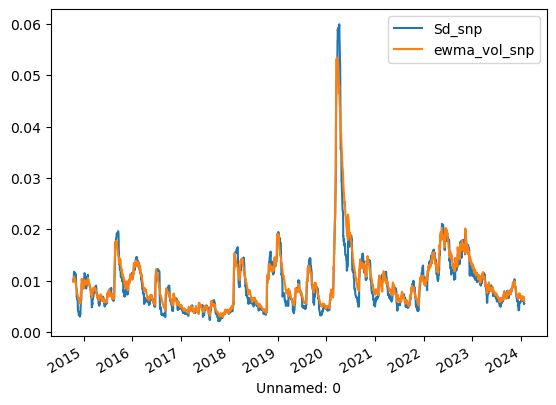

In [14]:
assets_df[['Sd_snp','ewma_vol_snp']].plot()

### Estimación de la covarianza con métodología EWMA

Primero extremos la covarianza semilla que corresponde al primer valor de la serie de covarianzas:

In [15]:
idx = pd.IndexSlice
cov = cov.loc[idx[:,'Log_Returns_btc'],'Log_Returns_snp'].reset_index(level = 1, drop = True)
corr = corr.loc[idx[:,'Log_Returns_btc'],'Log_Returns_snp'].reset_index(level = 1, drop = True)
assets_df = assets_df.join(cov.rename('Cov'), how = 'inner')
assets_df = assets_df.join(corr.rename('Corr'), how = 'inner')
cov_subzero =  assets_df['Cov'].iloc[0]
corr

Unnamed: 0
2014-10-16   -0.283181
2014-10-17   -0.211406
2014-10-20   -0.199882
2014-10-21   -0.149176
2014-10-22   -0.121032
                ...   
2024-01-22    0.012567
2024-01-23    0.159652
2024-01-24    0.146490
2024-01-25    0.145077
2024-01-26    0.141569
Name: Log_Returns_snp, Length: 2335, dtype: float64

In [16]:
assets_df['XY'] = assets_df['Log_Returns_snp']*assets_df['Log_Returns_btc']
assets_df.loc[:,'Covariance (ewma)'] = calculateEWMACov(assets_df['XY'],cov_subzero, 0.94)

<Axes: xlabel='Unnamed: 0'>

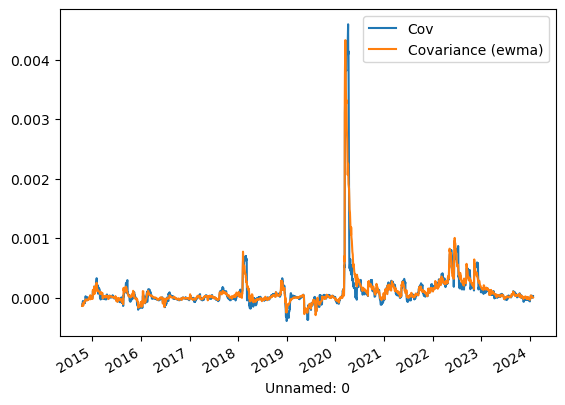

In [17]:
assets_df[['Cov','Covariance (ewma)']].plot()

Podemos obtener a su vez una correlación estimada por ewma y compararla con la correlación tipo pearson. 

<Axes: xlabel='Unnamed: 0'>

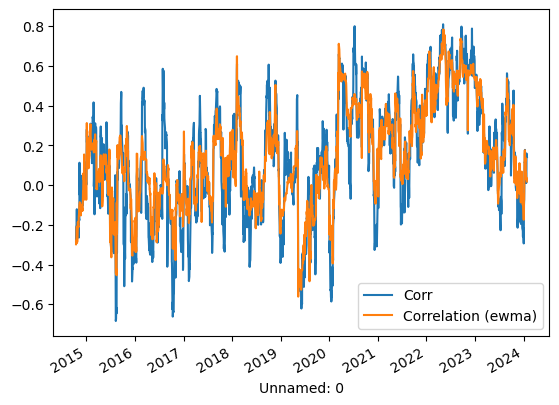

In [18]:
assets_df['Correlation (ewma)'] = assets_df['Covariance (ewma)'] / (assets_df['ewma_vol_snp']*(assets_df['ewma_vol_btc']))   
assets_df[['Corr','Correlation (ewma)']].plot()                                             

### Ejercicio:

Encuentre el coeficiente de Hurst para la acción de Microsoft y para alguna realización de las variables aleatorias. Usando la librería Hurst.

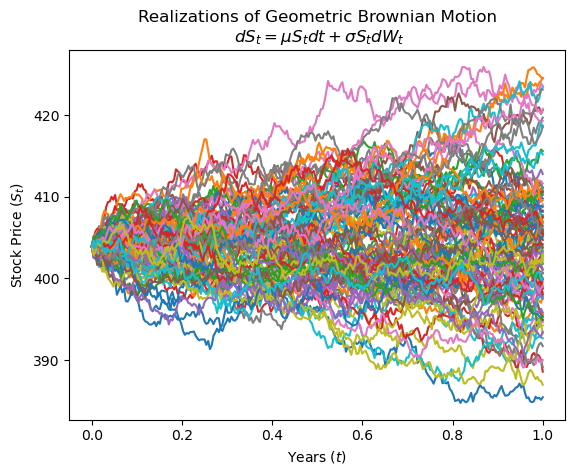

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from librerias.finance_operators import calculateLogReturns


stocks_df = pd.read_csv('datos\\'+'Tech Stocks.csv', encoding='utf-8', sep = ';')
stocks_df.index = pd.to_datetime(stocks_df.iloc[:,0], utc= True)
stocks_df = stocks_df.iloc[:,1:]
stocks_df

microsoft_stock = stocks_df.loc[:,'Microsoft']
microsoft_stock
log_returns_microsoft = calculateLogReturns(microsoft_stock)
# Parameters
# drift coefficent
mu = log_returns_microsoft.mean()
# number of steps
n = 252
# time in years
T = 1
# number of sims
M = 100
# initial stock price
S0 = microsoft_stock.iloc[-1]
# volatility
sigma = log_returns_microsoft.std()

# calc each time step
dt = T/n

# simulation using numpy arrays
St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(M,n)).T
)

# include array of 1's
St = np.vstack([np.ones(M), St])

# multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0). 
St = S0 * St.cumprod(axis=0)

# Define time interval correctly 
time = np.linspace(0,T,n+1)

# Require numpy array that is the same shape as St
tt = np.full(shape=(M,n+1), fill_value=time).T

plt.plot(tt, St)
plt.xlabel("Years $(t)$")
plt.ylabel("Stock Price $(S_t)$")
plt.title(
    "Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$"
)
plt.show()

In [20]:
realizations = pd.DataFrame(St)
realizations

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,403.929993,403.929993,403.929993,403.929993,403.929993,403.929993,403.929993,403.929993,403.929993,403.929993,...,403.929993,403.929993,403.929993,403.929993,403.929993,403.929993,403.929993,403.929993,403.929993,403.929993
1,403.073114,404.410760,404.742099,404.882194,404.161908,402.578097,404.882550,402.965375,403.875588,404.105941,...,404.463372,403.868152,404.417523,403.726607,404.092796,403.326589,403.489897,403.760114,402.885254,404.641536
2,403.292418,403.867176,405.552881,404.520126,404.545361,402.819789,404.524157,403.351638,403.841547,403.818861,...,404.846037,403.780637,404.559468,403.865165,403.425872,402.904128,404.374135,404.648205,403.239698,403.720084
3,403.762014,403.338078,405.415146,404.465549,403.775882,402.988359,404.176113,403.500130,404.533650,404.014583,...,405.428792,403.747027,405.239077,403.825338,402.849714,402.698317,404.783886,404.869983,404.403256,404.704010
4,402.493830,403.275899,405.680203,403.906664,403.558576,402.948168,404.426239,402.791536,405.000987,403.746147,...,405.389765,403.425696,404.861619,404.781340,402.492766,402.663190,404.737676,403.968144,404.226979,404.440968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,400.061582,396.622182,404.916892,394.489053,412.213848,405.259738,394.908061,400.677256,407.808077,392.583165,...,405.771472,405.144791,400.811609,408.310521,393.575236,404.609488,399.321540,406.925521,402.214805,400.239466
249,400.281627,397.500593,405.110515,394.085458,412.396107,405.493312,395.220680,401.215317,407.447782,392.737888,...,406.544396,405.803116,400.085968,407.646825,393.368481,404.944089,398.773947,407.168229,402.112496,400.755571
250,399.948075,397.236026,405.819245,394.081259,412.867639,405.259433,394.858849,400.908202,408.113848,392.911723,...,406.003350,406.886692,400.167075,406.838407,393.037416,405.778828,398.364846,405.445267,402.235132,400.813744
251,400.026643,397.011878,404.953604,394.640472,413.356922,405.127764,394.667799,400.871656,408.464796,392.778406,...,405.565857,407.452209,400.484006,405.939833,392.879109,405.832567,398.775228,406.361138,401.873026,399.812608


In [21]:
realization_1 = calculateLogReturns(realizations.iloc[:,0])
realization_1

0           NaN
1     -0.002124
2      0.000544
3      0.001164
4     -0.003146
         ...   
248    0.000648
249    0.000550
250   -0.000834
251    0.000196
252   -0.000150
Name: 0, Length: 253, dtype: float64

In [22]:
np.random.seed(42)
random_changes = 1. + np.random.randn(99999) / 1000.
series = np.cumprod(random_changes)  # create a random walk from random changes
series

array([1.00049671, 1.00035838, 1.0010063 , ..., 1.04736612, 1.04779468,
       1.0475735 ])

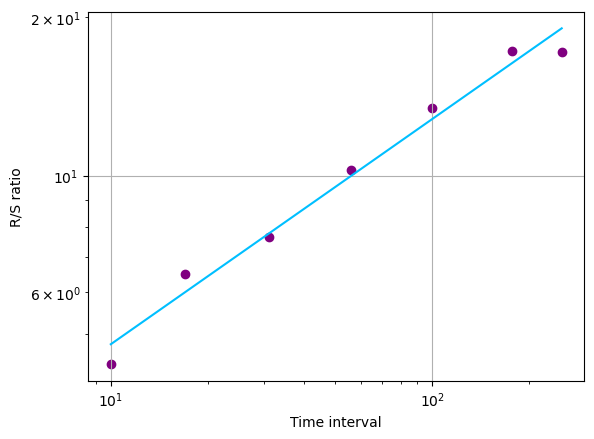

H=0.4277, c=1.7867


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from librerias.hurst import compute_Hc, random_walk

H, c, data = compute_Hc(realizations.iloc[:,99], kind='price', simplified=True)
H
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

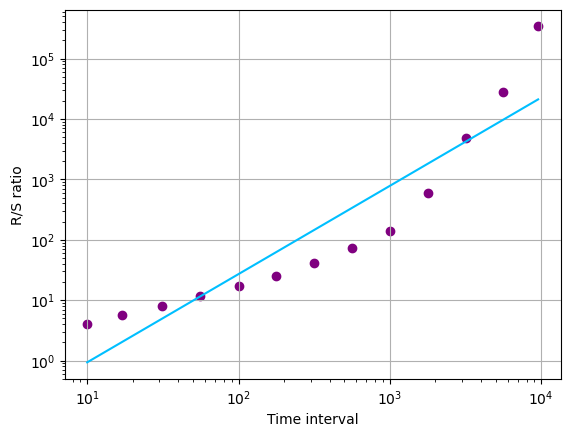

H=1.4605, c=0.0324


In [24]:
H, c, data = compute_Hc(microsoft_stock, kind='price', simplified=True)
H

# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

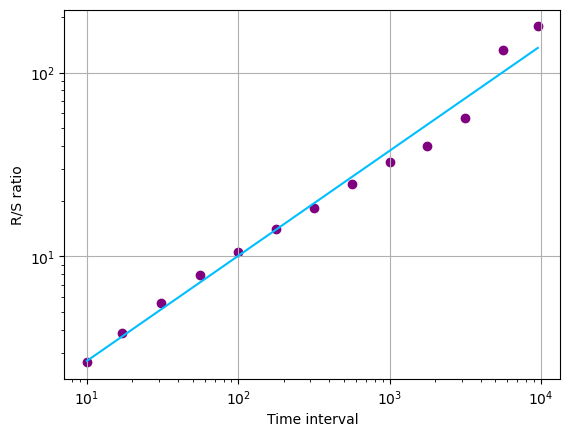

H=0.5713, c=0.7253


In [25]:
H, c, data = compute_Hc(microsoft_stock, kind='price', simplified=False)
H
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

In [26]:
H, c, data = compute_Hc(log_returns_microsoft.dropna(), kind='change', simplified=False)
H

0.5617814504345068

### Referencias 

EDHEC-Risk Institute (2019). Chapter 1.1 – Technical Supplement: Scientific. Lectures Notes for Advances in Asset Allocation Seminar 2020.
